# Importing the dataset

In [49]:
import pandas as pd
df = pd.read_csv('dataset/bitcoin_price_Training - Training.csv')

df = df.iloc[::-1]
df.head()

,Date,Open,High,Low,Close,Volume,Market Cap
1555,"Apr 28, 2013",135.30,135.98,132.10,134.21,-,"1,500,520,000"
1554,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000"
1553,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000"
1552,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000"
1551,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000"


In [50]:
df['Date'] = pd.to_datetime(df['Date'])

df = df.set_index('Date')

df.shape

(1556, 6)

<Axes: xlabel='Date'>

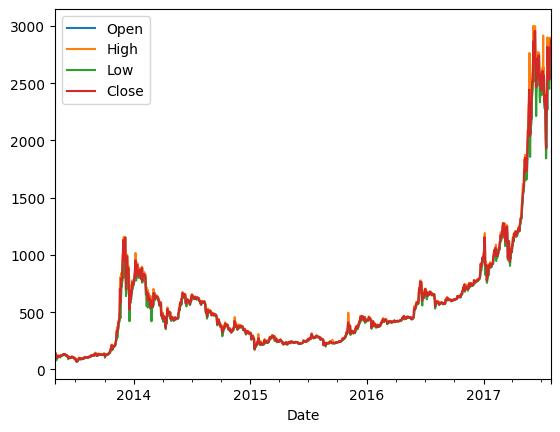

In [51]:
df.plot()

# Preprocessing

In [52]:
df.duplicated().sum()

0

In [53]:
df.isnull().sum()

Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64

## Extract Date Features

In [54]:
df.reset_index(inplace=True)

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter
df['DayOfYear'] = df['Date'].dt.dayofyear
df['IsWeekend'] = df['Date'].dt.weekday >= 5
df['IsStartOfMonth'] = df['Date'].dt.is_month_start
df['IsEndOfMonth'] = df['Date'].dt.is_month_end

df_date = df['Date']

df.drop(columns=['Date'],inplace=True)

### Imputing 

In [55]:
df['Volume']=df['Volume'].str.split(',').str.join('')
df['Market Cap']=df['Market Cap'].str.split(',').str.join('')

df.loc[df['Volume'] == '-', 'Volume'] = None

df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

df['Volume'] = df['Volume'].interpolate(method='linear', limit_direction='both')

df.head(1)

,Open,High,Low,Close,Volume,Market Cap,Year,Month,Day,Weekday,WeekOfYear,Quarter,DayOfYear,IsWeekend,IsStartOfMonth,IsEndOfMonth
0,135.3,135.98,132.1,134.21,46862700.0,1500520000,2013,4,28,6,17,2,118,True,False,False


### Encoding

In [56]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()

encoder = LabelEncoder()

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = encoder.fit_transform(df[col])
        
df_encoded.head(1)

,Open,High,Low,Close,Volume,Market Cap,Year,Month,Day,Weekday,WeekOfYear,Quarter,DayOfYear,IsWeekend,IsStartOfMonth,IsEndOfMonth
0,135.3,135.98,132.1,134.21,46862700.0,1500520000,2013,4,28,6,17,2,118,True,False,False


## Train, Test Split

In [57]:
X = df_encoded.drop(columns=['Close'])
y = df_encoded['Close']

In [58]:
from sklearn.model_selection import train_test_split

X = pd.concat([df_date, X], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)

train_dates = X_train['Date']
test_dates = X_test['Date']

X_train.drop(columns=['Date'], inplace=True)
X_test.drop(columns=['Date'], inplace=True)

# test_size = 0.2

# # Determine the index position for the cutoff date
# cutoff_index = int(len(df) * (1 - test_size))

# df_train = df.iloc[:cutoff_index]
# df_test = df.iloc[cutoff_index:]

# df_train.head(1)

### Scaling

In [59]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Feature Selection

In [60]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest

k = 7

selector = SelectKBest(score_func=mutual_info_regression, k=k)

X_train_selectK = pd.DataFrame(selector.fit_transform(X_train_scaled, y_train), columns=X_train.columns[selector.get_support()])
X_test_selectK = pd.DataFrame(selector.transform(X_test_scaled), columns=X_test.columns[selector.get_support()])

X_train_selectK.head(1)

,Open,High,Low,Market Cap,Month,WeekOfYear,DayOfYear
0,0.061611,0.056787,0.063943,0.054878,0.272727,0.307692,0.321429


### Checking Stationary (Differencing) for ARIMA paramater

In [61]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [62]:
check_stationarity(y_train)

ADF Statistic: -1.975696
p-value: 0.297330
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Non-stationary


In [63]:
check_stationarity(y_train.diff(periods=1).dropna())

ADF Statistic: -8.558415
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary


# Evaluate Model Function

In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2.0 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

def mean_bias_deviation(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(y_pred - y_true)

def evaluate_model(model_name, dates, test_data, predictions, train_data=None):
    mae = mean_absolute_error(test_data, predictions)
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_data, predictions)

    mape = mean_absolute_percentage_error(test_data, predictions)
    smape = symmetric_mean_absolute_percentage_error(test_data, predictions)
    mbd = mean_bias_deviation(test_data, predictions)

    print(f'{model_name}:\nMAE: {mae:.3f} -- MSE: {mse:.3f} -- RMSE: {rmse:.3f} -- R²: {r2:.3f}')
    print(f'MAPE: {mape:.3f} -- sMAPE: {smape:.3f} -- MBD: {mbd:.3f}')

    plot_results(model_name, dates, test_data, predictions)


def plot_results(model_name, dates, test_data, predictions):

  plt.figure(figsize=(10, 6))

  plt.plot(dates, test_data, label='Actual', color='blue')

  plt.plot(dates, predictions, label='Predicted', color='red')

  plt.xlabel('Date')
  plt.ylabel('Value')
  plt.title(f'Actual vs Predicted Values ({model_name})')
  plt.legend()
  plt.show()

# Training

### ARIMA (with Walk Forward Validation)


Predicitng Values using ARIMA ...
ARIMA:
MAE: 29.838 -- MSE: 3363.269 -- RMSE: 57.994 -- R²: 0.993
MAPE: 2.226 -- sMAPE: 2.228 -- MBD: -5.460


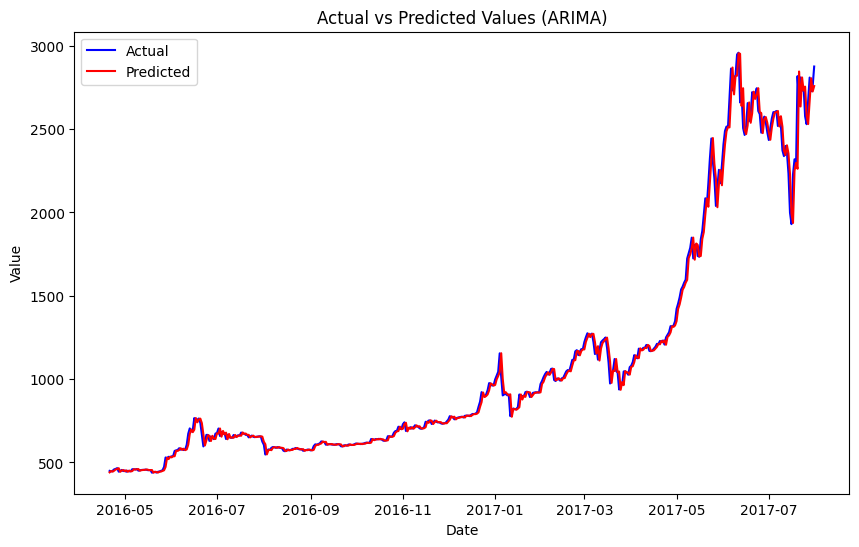

In [65]:
from statsmodels.tsa.arima.model import ARIMA

predictions = []

train = [x for x in y_train]
test = [x for x in y_test]

history = train.copy()

print("Predicitng Values using ARIMA ...")

for i in range(len(test)):

  model = ARIMA(history, order=(2,1,0))
  model_fit = model.fit()

  output = model_fit.forecast()

  y_hat = output[0]

  predictions.append(y_hat)

  history.append(test[i])

  # print(f'Predicted: {y_hat:.2f} Expected: {test[i]}')

evaluate_model('ARIMA', test_dates, test, predictions)

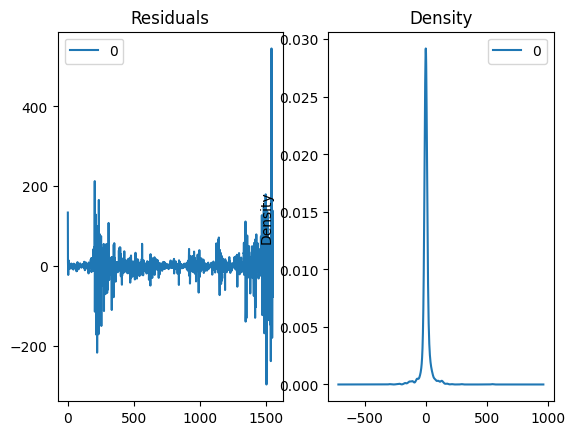

In [26]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### Prophet

Predicting Values using Prophet ...
(1556, 2)
Prophet:
MAE: 141.547 -- MSE: 52708.613 -- RMSE: 229.584 -- R²: 0.887
MAPE: 10.514 -- sMAPE: 11.150 -- MBD: -101.135


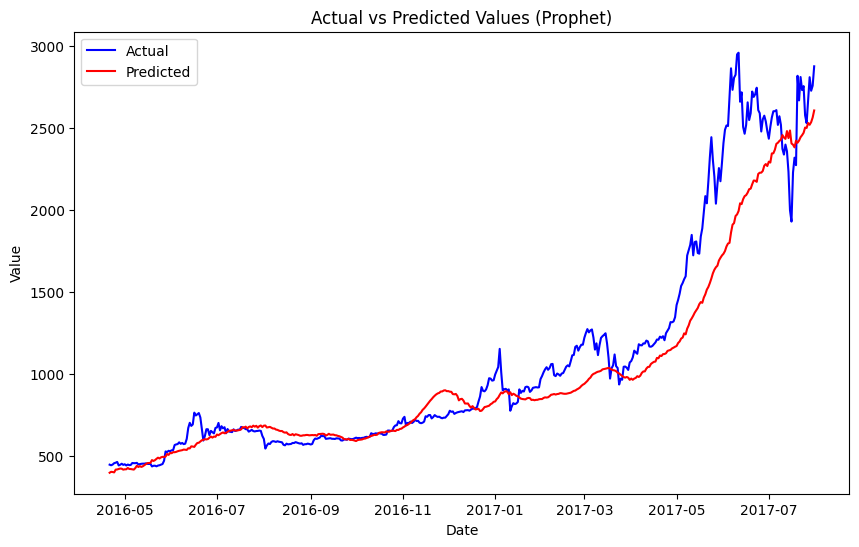

In [66]:
from prophet import Prophet
import logging

# Suppress cmdstanpy logging messages
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Initialize empty list to store forecasts
all_forecasts = []

# Prepare training data
train = pd.concat([train_dates, y_train], axis=1)
train.columns = ['ds', 'y']

# Prepare testing data
test = pd.concat([test_dates, y_test], axis=1)
test.columns = ['ds', 'y']

# Copy the training data to history
history = train.copy()

print("Predicting Values using Prophet ...")

# Iterate through each observation in the test set
for i in range(len(test)):
    
    prophet_model = Prophet()
    prophet_model.fit(history)
    
    future = pd.DataFrame({'ds': [test.iloc[i]['ds']]}) 
    forecast = prophet_model.predict(future)
    
    all_forecasts.append(forecast.iloc[0]['yhat'])
    
    next_observation = pd.DataFrame(test.iloc[i]).T 
    history = pd.concat([history, next_observation], ignore_index=True)
    
print(history.shape)
    
predictions = pd.Series(all_forecasts, index=test['ds'])

evaluate_model('Prophet', test['ds'], test['y'], predictions)


### Prophet without Walk Forward (Bad Results)

Prophet:
MAE: 484.186 -- MSE: 595700.923 -- RMSE: 771.817 -- R²: -0.277
MAPE: 32.117 -- sMAPE: 42.571 -- MBD: -483.601


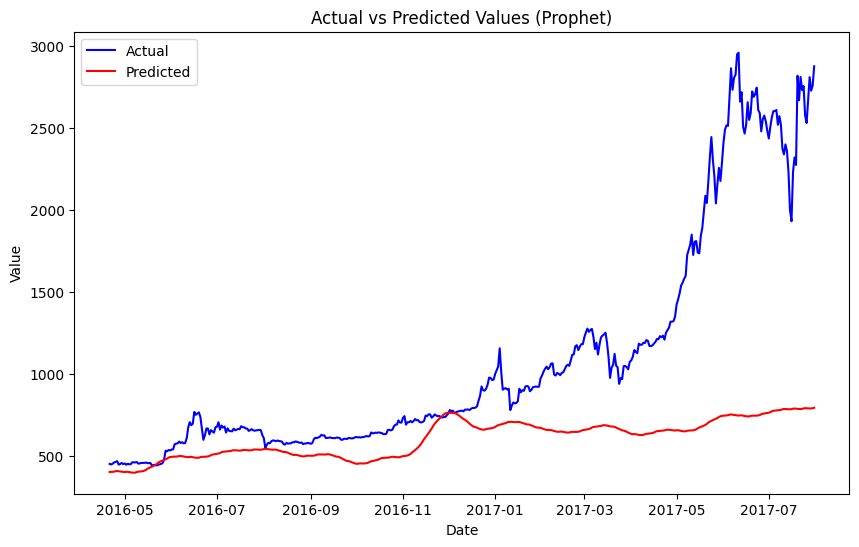

In [67]:
# predict with prophet 
prophet_model2 = Prophet()
prophet_model2.fit(train)

future = pd.DataFrame({'ds': test_dates})
forecast = prophet_model2.predict(future)

predictions = forecast['yhat']

evaluate_model('Prophet', test_dates, y_test, predictions)

### XGB, Random Forest & SVM


In [68]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Define models with corrected parameters for regression
models = [
    ("RandomForestRegressor", RandomForestRegressor(criterion='friedman_mse', max_depth=10, n_estimators=200)),
    ("SVR", SVR(C=10, kernel='rbf', gamma='auto')),
    ("XGBoost", XGBRegressor(max_depth=5, n_estimators=300, learning_rate=0.3, random_state=42))
]

In [69]:
for model_name, model in models:
    print("Training", model_name, "...")
    model.fit(X_train_selectK, y_train)

Training RandomForestRegressor ...
Training SVR ...
Training XGBoost ...


RandomForestRegressor:
MAE: 263.964 -- MSE: 328380.674 -- RMSE: 573.045 -- R²: 0.296
MAPE: 12.382 -- sMAPE: 15.969 -- MBD: -241.660


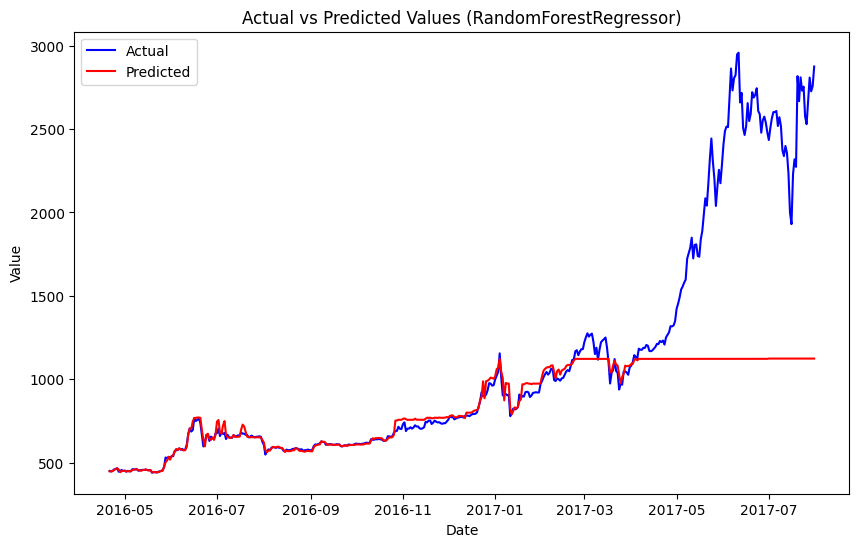

SVR:
MAE: 384.338 -- MSE: 631568.422 -- RMSE: 794.713 -- R²: -0.354
MAPE: 18.829 -- sMAPE: 27.159 -- MBD: -375.719


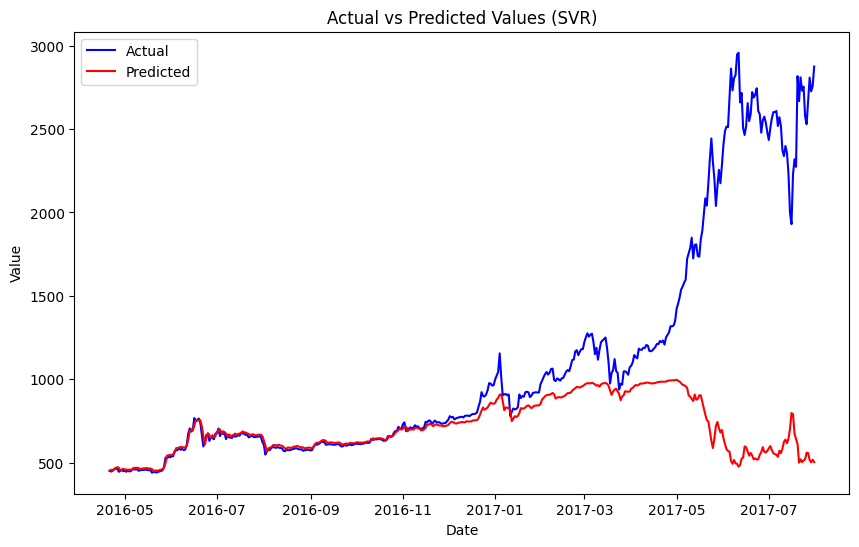

XGBoost:
MAE: 262.916 -- MSE: 326572.841 -- RMSE: 571.466 -- R²: 0.300
MAPE: 12.335 -- sMAPE: 15.928 -- MBD: -249.601


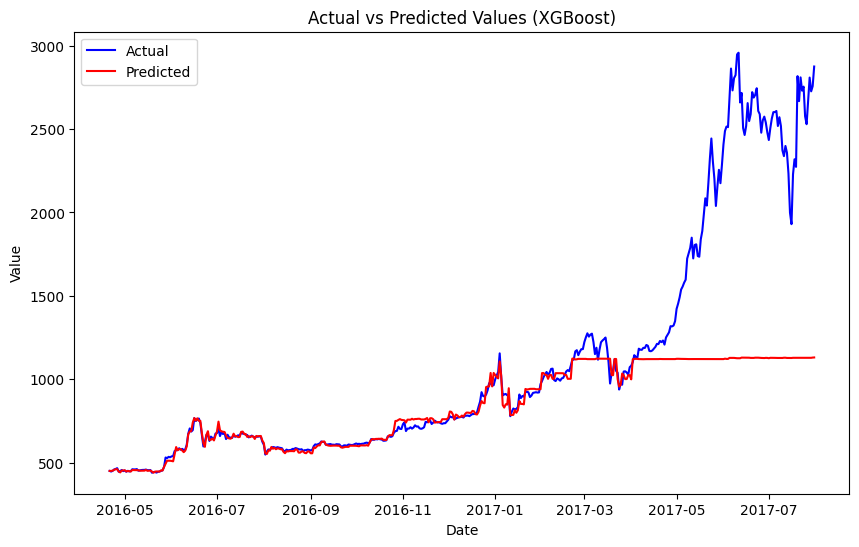

In [70]:
for model_name, model in models:
    predictions = model.predict(X_test_selectK)
    evaluate_model(model_name, test_dates, y_test, predictions)